## LTC Model deployment

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from api_keys import coinapi_key

2023-09-14 13:44:23.316442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:02:09.8730000Z', 'time_close': '2023-01-02T23:55:47.2360000Z', 'price_open': 71.01, 'price_high': 77.01, 'price_low': 70.09, 'price_close': 74.75, 'volume_traded': 12597.08873021, 'trades_count': 1357}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:02:07.6980000Z', 'time_close': '2023-01-03T23:55:34.7550000Z', 'price_open': 74.59, 'price_high': 76.38, 'price_low': 73.76, 'price_close': 75.6, 'volume_traded': 7900.38087519, 'trades_count': 899}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:01:13.2740000Z', 'time_close': '2023-01-04T23:55:12.4840000Z', 'price_open': 75.44, 'price_high': 77.89, 'price_low': 74.41, 'price_close': 75.51, 'volume_traded': 11627.82451562, 'trades_count': 1

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:02:09.8730000Z,2023-01-02T23:55:47.2360000Z,71.01,77.01,70.09,74.75,12597.088730,1357
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:02:07.6980000Z,2023-01-03T23:55:34.7550000Z,74.59,76.38,73.76,75.60,7900.380875,899
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:01:13.2740000Z,2023-01-04T23:55:12.4840000Z,75.44,77.89,74.41,75.51,11627.824516,1374
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:02:16.9880000Z,2023-01-05T23:56:30.5730000Z,75.60,76.16,73.65,74.01,7860.937082,790
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:03:20.2010000Z,2023-01-06T23:59:41.9260000Z,73.95,76.53,72.66,75.93,13966.363517,1259


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
# data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,74.75
2023-01-03,75.60
2023-01-04,75.51
2023-01-05,74.01
2023-01-06,75.93
...,...
2023-09-10,61.13
2023-09-11,58.75
2023-09-12,59.93


In [5]:
close = data['Close']

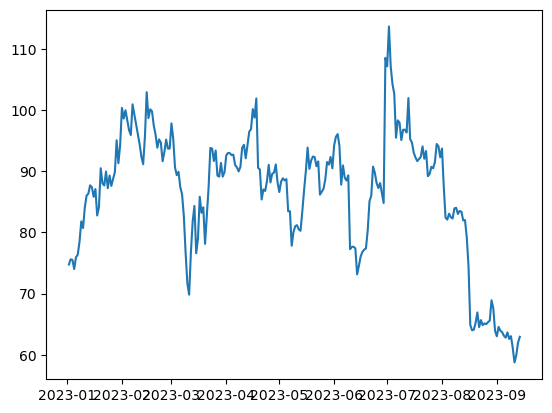

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 1 month lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2023-01-08,78.46,76.35,75.93,74.01,75.51,75.60,74.75
2023-01-09,81.80,78.46,76.35,75.93,74.01,75.51,75.60
2023-01-10,80.70,81.80,78.46,76.35,75.93,74.01,75.51
2023-01-11,84.07,80.70,81.80,78.46,76.35,75.93,74.01
2023-01-12,86.01,84.07,80.70,81.80,78.46,76.35,75.93
...,...,...,...,...,...,...,...
2023-09-10,61.13,63.05,62.60,63.66,62.81,63.12,63.71
2023-09-11,58.75,61.13,63.05,62.60,63.66,62.81,63.12
2023-09-12,59.93,58.75,61.13,63.05,62.60,63.66,62.81


In [8]:
#create array of dates for plotting from new index. 
dates = shifted_df.index

dates.shape

(246,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np


shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(246, 7)

In [10]:
#Load Trained Model
model = load_model("H5_Files/ltc_7_day.h5")

2023-09-14 13:45:21.211385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 28ms/step
[4.150151, 4.1677146, 4.1859736, 4.2030854, 4.2186713, 4.235497, 4.2534122]
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21


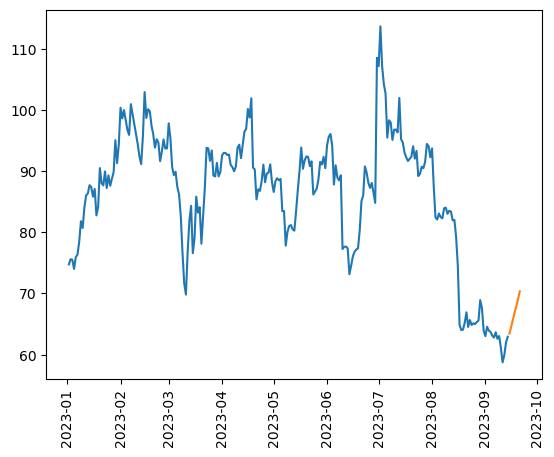

In [24]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [25]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction
Date,,
2023-01-08,78.46,NaN
2023-01-09,81.80,NaN
2023-01-10,80.70,NaN
2023-01-11,84.07,NaN
2023-01-12,86.01,NaN


In [26]:
past_future_df.tail()



,observed,future_prediction
Date,,
2023-09-17,NaN,65.757492
2023-09-18,NaN,66.892410
2023-09-19,NaN,67.943153
2023-09-20,NaN,69.096008
2023-09-21,NaN,70.345039


In [27]:
past_df = pd.read_csv('output/ltc_model.csv')

past_df = past_df[["future_prediction"]]

past_df = past_df.rename(columns={"future_prediction":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

,observed,future_prediction,past_pred
2023-01-08,78.46,NaN,NaN
2023-01-09,81.80,NaN,NaN
2023-01-10,80.70,NaN,NaN
2023-01-11,84.07,NaN,NaN
2023-01-12,86.01,NaN,NaN


In [28]:
df_combined.to_csv('output/ltc_model_hist.csv') 

In [29]:
past_future_df.to_csv('output/ltc_model.csv') 